# Problem Sheet 10 - A Complete scikit-learn Project

In this exercise, we will cover a complete data science project.
The underlying data set consists of different predictors (variables) explaining the median home values in different regions of California, USA.

This week, we focus on all the steps that come *before* our typical learning procedure starts, i.e., data preparation, data wrangling, feature generation, etc.

## Loading the data
We begin with the usual data and library imports and set the figure size for subsequent plots.

**Task**: Execute the following code cell and customize the path as necessary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set standard figure size
plt.rcParams['figure.figsize'] = (16,9)

# Read csv file
df = pd.read_csv('datasets/housing.csv')

## Getting an overview

**Task**: Use the methods `head()`, `info()` and `describe()` applied to a `pandas DataFrame` to get an overview of the data. Try to answer the following questions:
- Are there any missing values and, if so, in which columns/variables do they occur?
- Are there non-numerical variables?

**Observation**:

You should observe one categorical variable.

**Task**: How many different classes occur in this attribute?
You can use the method `value_counts()` of a `Series` object to count the occurences in each of the categories.

**Observations**:

Next, we take a look at histograms of the data.
We have already seen in previous labs that this can reveal important features of a data set.

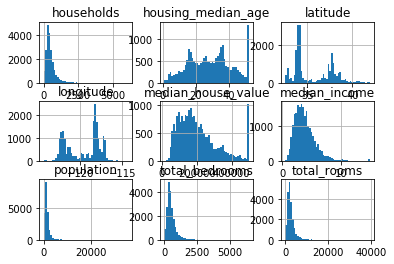

In [4]:
df.hist(bins=50);

**Observations**:
- The values of `housing_median_age` and `median_house_value` have been capped. This is not a priori a problem, but can lead to wrong price predictions beyond this level. We have to take care of this.
- The variables have different scales. A proper scaling can be necessary.
- Many of the variables are not normally distributed, but heavy-tailed, i.e., they tend to extend farther to the extremal values (in our case to the right). Since some of our algorithms assume that the data is normally distributed, we have be cautious.
- The medium income seems to be scaled in thousands of dollars, and the value seems to be capped at a medium income of 15, since there are exceptionally many samples with the value 15.0001.

**Task**: Have a look at `df.medium_income.value_counts()` to verify the last observation.

## Stratified Training-Test Splits

Until now, we have tried to get a better understanding of the data.
Before we look closer into price prediction
we want to make sure not to include what is known as data snooping bias.

In this project, we want to employ a split into a test and training set:
The function `train_test_split` splits the data randomly into two distinct sets.
This works well for fairly uniformly or normally distributed data, but can cause some problems for heavy-tailed attributes or categorical data with varying numbers of samples in each category.

For this reason we want to stratify our random split according to the attribute `median_income`.
Stratifying means that we choose our split in accordance with different classes.
This means nothing else than that the algorithm makes sure to include the same proportion of each class in both the test and the training set.

Pandas provides a method to set up categories from of a numerical variable that splits the data into equal-sized bins based on sample quantiles. This function is called `pd.qcut`.

**Task**: Use the function `pd.qcut` to split `median_income` into 5 categories. Store the output in a variable `income_cat`.
One could also label the categories using the optional `labels` parameter.
By default, labels is equal to the interval boundaries of the corresponding class.
You should keep the labels parameter unchanged because we only want to use this in our training-test split. 

**Task**: Split the data using the `train_test_split` function from `sklearn.model_selection` such that the test set contains approximately 20\% of the samples.
Set `random_state = 1` and `stratify = income_cat`.

## Visualizing the data
Here we try to visualize as many features of the data as possible.
In previous labs, we already used the scatterplot, but mainly with standard options.
The nice thing about scatterplots is that we can represent more than two features of the data set.
The following code cell plots every sample in our training set as one circle.
The variable `longitude` sets up the x-axis, `latitude` the y-axis. 

The optional parameters are as follows:
- `alpha = 0.4`: opacity of cicles
- `s = train.population / 100`: size of circles, i.e., the larger the population in the region, the larger the circle
- `c = 'median_house_value'`: color of the circle, i.e., the higher the median house value in the region, the brighter the color (this depends on the colormap `cmap`)

**Task**: Execute the following code and identify the two regions with higher house values.

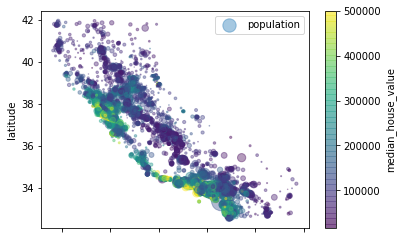

In [9]:
train.plot(kind='scatter', x = "longitude", y ="latitude", alpha=0.4,
          s = train.population/100, c = 'median_house_value',
          label='population', cmap = plt.get_cmap('viridis'),
          colorbar='true')

**Observation**:

**Task**: Copy and paste the code fragment from above. Adapt the code so that the color is determined by the `median_income` variable.

## Take a look at the correlation matrix

**Task**: Compute the correlation matrix of the training set.
Determine the variables with the highest correlation with `median_house_value`.
The output of the method `corr()` is a `pandas DataFrame` itself, and possesses the same methods, e.g., `sort_values()`.

**Observation**:

The next plot generates a heatmap of the correlation (assuming you named the correlation matrix `cm`).
Blue squares indicate a negative correlation, red ones a positive correlation.

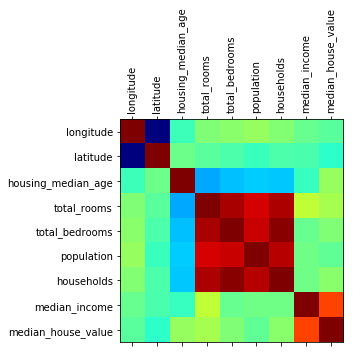

In [12]:
plt.matshow(cm, cmap=plt.get_cmap('jet'))
plt.xticks(range(len(cm.columns)), cm.columns, rotation='vertical');
plt.yticks(range(len(cm.columns)), cm.columns);

Finally, we look at the scatter matrix of the 4 most strongly positively correlated variables.
These are

    attr = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

**Task**: Execute the following code. What do you observe?

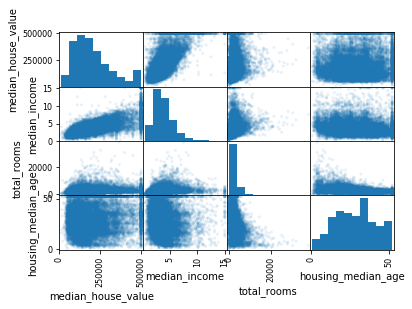

In [13]:
attr = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(train[attr], alpha=0.1);

**Observations**:

## Generate Combinations of Attributes

Now we want to try if we can do better with derived attributes.
This is an important step, and we did this already by the incorporation of powers of variables.
In this lab, we want to use a more reflected approach.
Since the number of total rooms in an area depends heavily on the size of the area, we might take the rooms per household into consideration.
Another interesting quantity could be the number of bedrooms per room, which we can get by dividing `total_bedrooms` through `total_rooms`.

**Task**: Expand your training set by two new variables `rooms_per_household` and `bedrooms_per_room`.
Afterwards, check the correlation of the new variables with `median_house_value`.
You should observe a correlation of -0.254417 for `bedrooms_per_room` vs. `median_house_value` and a corralation of 0.146569 for `rooms_per_household` vs. `median_house_value`.

**Observations**:

## Data Wrangling
Now we want to start to clean up the data.
We've already noted that the variable `total_bedrooms` contains some missing values.

In previous labs, we used to delete the samples from the data set, and this might be reasonable for this data set as well.
In this lab, we employ another common way to get around missing values, which is replacing the missing value with some *standard* value.
This *standard* value could be anything, even a constant or a optimistic/pessimistic guess.

Scikit-learn provides a class to do this job, called `SimpleImputer` from the module `sklearn.impute`.

**Task**:
Define a `SimpleImputer` that assigns the median value of an attribute over all (training) samples to all missing values (**Hint**: Use the option `strategy`).

**Caution**: As with other scaling methods, we should use the *training median* to fill out the missing values in both the *training and the test set*.

Unfortunately, the `SimpleImputer` is not able to handle non-numerical data.
Thus we have to split our data into the numerical attributes (i.e. everything but `ocean_proximity`) and the categorical one (`ocean_proximity`).

**Task**: If you defined your `SimpleImputer` as a variable `imp`, the following code cell should execute. It splits the data into numerical and non-numerical ones, and fits the imputer.

In [16]:
train_num = train.drop('ocean_proximity',axis=1)
train_cat = train['ocean_proximity']
imp.fit(train_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

**Task**:
You can look at the trained median values in each of the attributes with numerical values by calling `imp.statistics_`.

**Caution**:
The output of `imp.transform(train_num)` is a `numpy array`.
It can be converted easily into a `pandas DataFrame`.
This can be done by executing the following code snippet.

In [18]:
X = imp.transform(train_num)
df_num = pd.DataFrame(X, columns=train_num.columns)

Next, we want to look at the categorical data.

Simply assigning numerical values to the categories might be possible, but not the best choice, because this would introduce:
- an ordering among the categories
- the same distance between each of the categories in terms of *predictive power*

A better choice is the so-called *one-hot encoding* or *one-of-K scheme*.
We introduced this transformation in Homework 9 as well as in the lecture on Slide 112.
There, we used the pandas method `get_dummies` to do the job.
This time, we want to use the class `LabelBinarizer` from `sklearn.preprocessing`.
It essentially generates a `numpy array` $X$ with 

$$ X_{i,j} = \begin{cases} 1 & \text{sample $i$ belongs to category $j$}, \\ 0 & \text{otherwise}. \end{cases} $$

**Task**: Use a `LabelBinarizer` to transform the categorical data `train_cat` into an $n_\text{samples} \times 5$ `numpy array`.

You can see the classes via `cat_enc.classes_`.

In [20]:
cat_enc.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='<U10')

## Custom Transformers
As you can see above, there are a lot of steps to be carried out before we can actually apply a statistical learning method such as linear regression.
Altough `sklearn` provides a lot of useful transformers, we have to create our own for each learning task.
In the following, we want to implement such a custom transformer.
A `Transformer` is a class in sklearn, derived from an `Estimator`, which implements at least the methods `fit()` and `transform()`, as well as `fit_transform()`, which combines fitting and transformation.
We have already used many transformers, without exactly knowing what they are, e.g. `StandardScaler` or the `SimpleImputer`.
In contrast to a transformer, an `Estimator` implements only the method `fit()`.
A `Predictor` is an `Estimator` which additionally implements a `predict()` method as well as a `score()` method.

There is a nice article on [arxiv.org](https://arxiv.org/pdf/1309.0238v1.pdf) that describes the design pattern in `scikit-learn`.

Before we can start, we have to decide whether to stay with `pandas DataFrames` or switch to `numpy arrays`.
It might be tempting to stay with `DataFrames`, and there are situations where this might be beneficial, but in general, we should use `numpy arrays` (or sparse `scipy arrays`). As we already noticed, both the `SimpleImputer` and the `StandardScaler` return `numpy arrays`, even if we input a `pandas DataFrame`. Thus, it's advantageous from a computational point of view to use `numpy arrays`.

In order to add our new attributes `rooms_per_household` and `bedrooms_per_room`, we have to locate the columns by index and not by name.

**Task**:
Set the indices of the column indexes of `total_rooms`, `total_bedrooms` and `households`.

The next cell defines such a custom `Estimator`.
It sets up a new class derived by `BaseEstimator` and `TransformerMixin`.
The latter sets up the `fit_transform()` method for us simply by calling `transform()` after `fit()`.

**Task**:
Try to understand the following code cell.
It contains a number of items that might be new to you.
Ask questions!

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

# We derive our new class from an BaseEstimator and TransformerMixin
class AddRoomsPerHousehold(BaseEstimator, TransformerMixin): 
    
    # The constructor in Python is defined by the method __init__,
    # we have to pass self as a first argument in the functions to
    # be able to access the attributes of the class object.
    # The argument
    #     add_rooms_per_household = True
    # is a parameter with standard value 'True'.
    def __init__(self, add_rooms_per_household = True):
        self.add_rooms_per_household = add_rooms_per_household
    
    # Now, we define the fit-method, but there is nothing to do
    # here, so we only return the object itself, as you might
    # have noticed before.
    def fit(self, X, y = None):
        return self
    
    # Here, we define the transform method. We want to append a new
    # column that gives the number of rooms per household
    def transform(self, X, y = None):
        
        # We add the 'rooms_per_household' attribute only,
        # if add_rooms_per_household = True
        if self.add_rooms_per_household: 
            new_var = X[:,ix_rooms] / X[:,ix_households]
            return np.c_[X,new_var]
        else:
            return X

**Task**: Now, copy and paste the code from above and define a second class that adds the attribute `bedrooms_per_room`. Call your class `AddBedroomsPerRoom`.

## Setting up a Transformation Pipeline
The next step in our scikit-learn project walkthrough is to combine every preprocessing task in a `sklearn Pipeline`.
A `Pipeline` is a list of $n$ pairs, the first entry holds a name, the second a `Transformer`-object. 

**Task**:
Below you will find such a `Pipeline` for our non-categorical attributes.
If you did everthing right so far, you should be able to execute the following code cell.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('fill_nas', SimpleImputer(strategy='median')),
                         ('add_rooms_per_household', AddRoomsPerHousehold()),
                         ('add_bedrooms_per_room', AddBedroomsPerRoom()),
                         ('scaling', StandardScaler())])

**Task**:
A `Pipeline` consists of a number of transformers.
The last object might be an `Estimator`, a `Transformer` or a `Predictor`.
This determines its final behaviour.
In our case, `StandardScaler` comes last, which *defines* our `num_pipeline` as a `Transformer` in its own.
Therefore, we can call the method `fit_transform()` on it.
Try this out on our data set `train_num`!

One thing that we have so far done by hand was the splitting into numerical and categorical attributes.

Fortunately, the programming principle behind `scikit-learn` is avoid typing, see [Wikipedia](https://en.wikipedia.org/wiki/Duck_typing) for an explanation.
In a nutshell, this means that every class that has a method `fit()`, can be used as an `Estimator`, and every class that implements the methods `fit()`, `transform()` and `fit_transform()`, can be used as a `Transformer`.

Therefore, we define another `Transformer`-class that selects the columns by label and returns a numpy array.

**Task**:
Understand the following definition of the class `AttributeSelector`.

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeSelector(BaseEstimator, TransformerMixin): 
    
    def __init__(self, attributes):
        self.attributes = attributes
    
    def fit(self, X, y = None):
        return self # This again does nothing
    
    def transform(self, X, y = None):
        return X.loc[:,self.attributes].values

Below you will find the labels of the non-categorical and categorical columns in our data set.

In [28]:
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
            'total_bedrooms', 'population', 'households', 'median_income']
cat_cols = ['ocean_proximity']

**Task**: Copy the definition from `num_pipeline` and include the `AttributeSelector` as a new initial step.
Test the method `fit_transform()` on your training data `train` (and not `train_num`).

Now we want to define another pipeline for the categorical variable in your data set.
Unfortunatelly, the `LabelBinarizer` cannot be used in a `Pipeline` in the current version of `sklearn`.
With the function `super(SubClass, self)`, we are able to call methods from the `BaseClass`, which in our case is the original `LabelBinarizer` from `sklearn`.

In [30]:
class PipelineBinarizer(LabelBinarizer):
    def fit(self, X, y=None):
        super(PipelineBinarizer, self).fit(X)
        
    def transform(self, X, y=None):
        return super(PipelineBinarizer, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(PipelineBinarizer, self).fit(X).transform(X)

**Task**:
Define another pipeline for the categorical variable in your data set.
Start with the selection of the correct variable(s), and use the `PipelineBinarizer` from above.
Test the method `fit_transform()` on your training data `train` (and not `train_cat`).

Finally, we have to unite our preprocessed numerical and categorical  variables.
This can be done with `FeatureUnion` from `sklearn.pipeline`.

In [32]:
from sklearn.pipeline import FeatureUnion

unite_features = FeatureUnion([('num_pipe', num_pipeline),
                               ('cat_pipe', cat_pipeline)])

**Task**: Call the `unite_features.fit_transform()` method on your training data `train`.
Check, if everything has been set up correctly and store the output as a `numpy array` $X$.

## Application of a Learning Algorithm

Until now, we have preprocessed the data to prepare it for applying a learning algorithm.
Altough we had to introduce a lot of new functions and classes, most of this material was already considered in previous lectures.

After this lab, you should be able to define your own `Estimator`, `Transformer` or `Predictor`.
Arranging these objects in a `Pipeline` pays off in larger data science projects.
There are a number of advantages that are beyond of the scope of this notebook, but will hopefully be considered in an upcoming lab.
You can, for example, preprocess your test data without thinking about further details by

    Xtest = unite_features.transform(test)

**Task**: As a final task in this lab, we want to apply a simple linear regression to our training set and compute the RMSE (root mean squared error). It should be 68219.0015.